# Day 5: Factor Exposure Analysis

---

### 🎯 Learning Objectives
- Analyze portfolio factor exposures
- Understand factor risk contribution
- Decompose portfolio returns by factor
- Build factor-tilted portfolios


---| High β_MOM | Chasing momentum |

| High β_HML | Tilted to value |

### 📈 Why Factor Exposure Analysis Matters| High β_SMB | Tilted to small caps |

| High β_MKT | Aggressive equity exposure |

**Know WHAT risks you're taking, not just HOW MUCH risk.**|----------|--------|

| Exposure | Meaning |

### Key Concept

$$\text{Portfolio Return} = \alpha + \sum_{k=1}^{K} \beta_k^P \cdot F_k + \epsilon$$### Factor Exposure Interpretation



### Trading Applications| **Performance Attribution** | Was return from alpha or factor beta? |

| **Hedging** | Which factor exposures to neutralize? |

| Application | Insight Gained || **Style Analysis** | Is manager really doing what they claim? |

|-------------|---------------|| **Risk Attribution** | Where is risk coming from? |

In [7]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Constants
TRADING_DAYS = 252  # Trading days per year
RISK_FREE_RATE = 0.05  # Risk-free rate (5%)

# Download market data from Yahoo Finance
tickers = ['AAPL', 'MSFT', 'GOOGL', 'JPM']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data from Yahoo Finance...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()
log_returns = np.log(prices / prices.shift(1)).dropna()

print(f"✅ Data loaded: {prices.shape[0]} days")

📥 Downloading data from Yahoo Finance...
✅ Data loaded: 1254 days


## 1. Construct Factors

| **MOM** | Winners - Losers | Momentum bet |

### 🎯 Building Our Factor Set| **HML** | Value - Growth | Value bet |

| **SMB** | Small - Big | Size bet |

| Factor | Construction | Trading Use || **MKT** | Market - Rf | Equity exposure |
|--------|--------------|-------------|

In [8]:
# Market factor
daily_rf = RISK_FREE_RATE / TRADING_DAYS
MKT = returns['AAPL'] - daily_rf

# SMB - Size factor
volatilities = returns.std()
median_vol = volatilities.median()
small = [s for s in volatilities[volatilities > median_vol].index if s != 'AAPL']
big = [s for s in volatilities[volatilities <= median_vol].index if s != 'AAPL']
SMB = returns[small].mean(axis=1) - returns[big].mean(axis=1)

# HML - Value factor
past_ret = returns.rolling(126).mean().iloc[-1]
median_ret = past_ret.median()
value = [s for s in past_ret[past_ret < median_ret].index if s != 'AAPL']
growth = [s for s in past_ret[past_ret >= median_ret].index if s != 'AAPL']
HML = returns[value].mean(axis=1) - returns[growth].mean(axis=1)

# MOM - Momentum factor
mom_12m = returns.rolling(252).mean().iloc[-1]
mom_1m = returns.rolling(21).mean().iloc[-1]
mom_signal = mom_12m - mom_1m  # 12-1 momentum
median_mom = mom_signal.median()
winners = [s for s in mom_signal[mom_signal >= median_mom].index if s != 'AAPL']
losers = [s for s in mom_signal[mom_signal < median_mom].index if s != 'AAPL']
MOM = returns[winners].mean(axis=1) - returns[losers].mean(axis=1)

# Combine factors
factors = pd.DataFrame({
    'MKT': MKT,
    'SMB': SMB,
    'HML': HML,
    'MOM': MOM
}).dropna()

print("\n📊 Factor Statistics (Annualized):")
print(f"{'Factor':<8} {'Return':<12} {'Volatility':<12} {'Sharpe':<10}")
print("-"*45)
for col in factors.columns:
    ret = factors[col].mean() * TRADING_DAYS
    vol = factors[col].std() * np.sqrt(TRADING_DAYS)
    sharpe = ret / vol if vol > 0 else 0
    print(f"{col:<8} {ret:<12.2%} {vol:<12.2%} {sharpe:<10.3f}")


📊 Factor Statistics (Annualized):
Factor   Return       Volatility   Sharpe    
---------------------------------------------
MKT      10.41%       27.70%       0.376     
SMB      10.21%       24.98%       0.409     
HML      -10.21%      24.98%       -0.409    
MOM      -8.66%       21.51%       -0.403    


## 2. Calculate Stock Factor Exposures

In [9]:
def get_factor_exposures(stock_returns, factors):
    """Calculate factor exposures via regression."""
    excess_returns = stock_returns - daily_rf
    aligned = pd.concat([excess_returns, factors], axis=1).dropna()
    y = aligned.iloc[:, 0]
    X = sm.add_constant(aligned[factors.columns])
    model = sm.OLS(y, X).fit()
    return model

# Calculate exposures for all stocks
exposures = {}
for stock in returns.columns:
    if stock != 'AAPL':
        try:
            model = get_factor_exposures(returns[stock], factors)
            exposures[stock] = {
                'alpha': model.params['const'] * TRADING_DAYS,
                'MKT': model.params['MKT'],
                'SMB': model.params['SMB'],
                'HML': model.params['HML'],
                'MOM': model.params['MOM'],
                'R2': model.rsquared
            }
        except:
            pass

exposure_df = pd.DataFrame(exposures).T

print("\n" + "="*70)
print("FACTOR EXPOSURES (TOP 10 by R²)")
print("="*70)
top10 = exposure_df.nlargest(10, 'R2')
print(top10.round(3))


FACTOR EXPOSURES (TOP 10 by R²)
       alpha    MKT    SMB    HML    MOM     R2
GOOGL  0.112  0.489  0.406 -0.406 -0.046  0.751
MSFT   0.112  0.489  0.072 -0.072  0.621  0.636
JPM    0.112  0.489 -0.261  0.261 -0.713  0.594


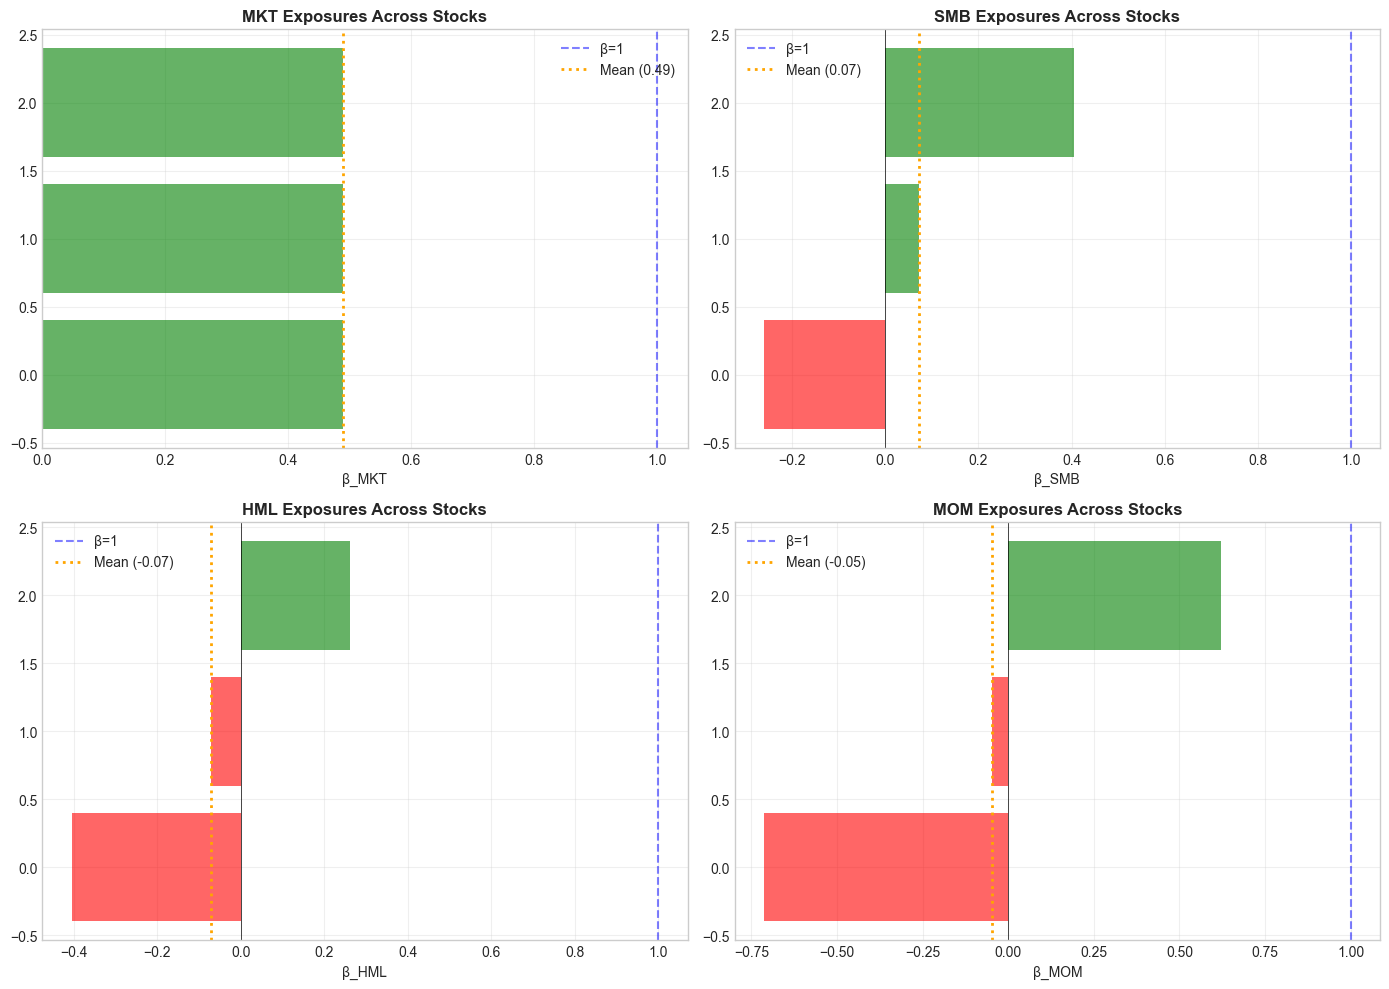

In [10]:
# Visualize factor exposures
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

factor_cols = ['MKT', 'SMB', 'HML', 'MOM']

for i, (ax, factor) in enumerate(zip(axes.flatten(), factor_cols)):
    exposures_sorted = exposure_df[factor].sort_values()
    
    colors = ['red' if x < 0 else 'green' for x in exposures_sorted]
    ax.barh(range(len(exposures_sorted)), exposures_sorted.values, color=colors, alpha=0.6)
    ax.axvline(0, color='black', linewidth=0.5)
    ax.axvline(1, color='blue', linestyle='--', alpha=0.5, label='β=1')
    ax.set_title(f'{factor} Exposures Across Stocks', fontweight='bold')
    ax.set_xlabel(f'β_{factor}')
    ax.grid(True, alpha=0.3)
    
    # Add mean line
    mean_exp = exposure_df[factor].mean()
    ax.axvline(mean_exp, color='orange', linestyle=':', linewidth=2, label=f'Mean ({mean_exp:.2f})')
    ax.legend()

plt.tight_layout()
plt.show()

## 3. Portfolio Factor Exposure

In [11]:
# Create sample portfolio
portfolio_stocks = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'GS']
portfolio_stocks = [s for s in portfolio_stocks if s in returns.columns]

# Equal weight portfolio
n_stocks = len(portfolio_stocks)
weights = np.ones(n_stocks) / n_stocks

# Calculate portfolio returns
portfolio_returns = (returns[portfolio_stocks] * weights).sum(axis=1)

# Portfolio factor exposure
portfolio_model = get_factor_exposures(portfolio_returns, factors)

print("\n" + "="*60)
print("PORTFOLIO FACTOR EXPOSURES (Equal Weight)")
print("="*60)
print(f"Stocks: {portfolio_stocks}")
print(f"\n{'Factor':<12} {'Exposure':<12} {'t-stat':<12} {'Significant'}")
print("-"*50)

for param in portfolio_model.params.index:
    if param == 'const':
        name = 'Alpha (Ann.)'
        value = portfolio_model.params[param] * TRADING_DAYS
    else:
        name = param
        value = portfolio_model.params[param]
    
    t_stat = portfolio_model.tvalues[param]
    sig = "✓" if portfolio_model.pvalues[param] < 0.05 else "✗"
    
    print(f"{name:<12} {value:<12.4f} {t_stat:<12.2f} {sig}")

print(f"\nR²: {portfolio_model.rsquared:.4f}")


PORTFOLIO FACTOR EXPOSURES (Equal Weight)
Stocks: ['AAPL', 'MSFT', 'GOOGL', 'JPM']

Factor       Exposure     t-stat       Significant
--------------------------------------------------
Alpha (Ann.) 0.0840       1.61         ✗
MKT          0.6169       49.66        ✓
SMB          0.0543       7.68         ✓
HML          -0.0543      -7.68        ✓
MOM          -0.0345      -2.13        ✓

R²: 0.7023


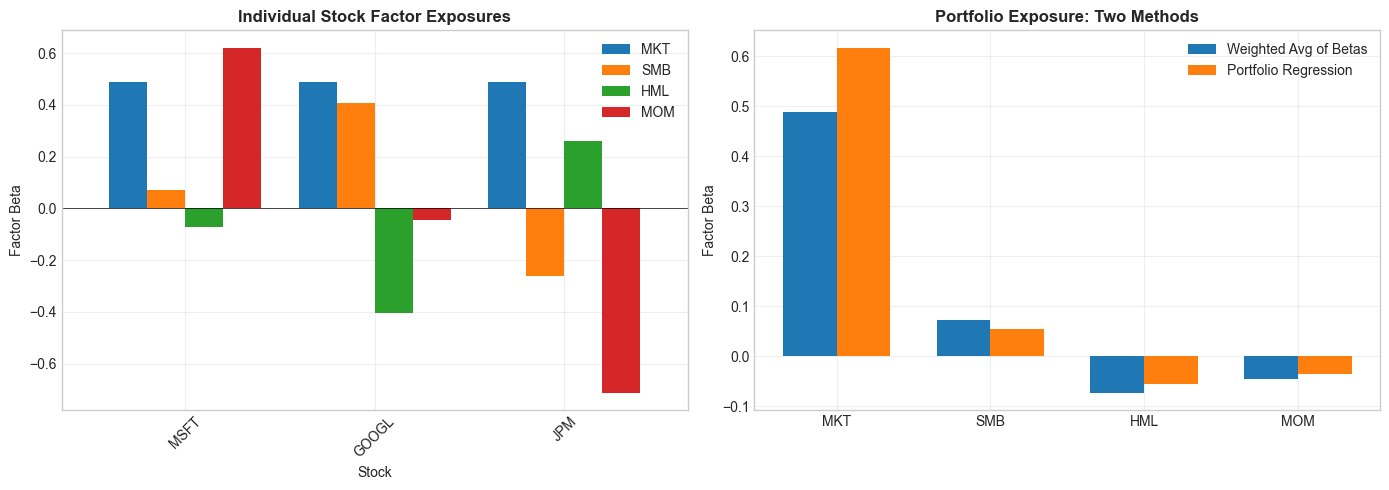


💡 Portfolio beta ≈ Weighted average of individual betas


In [13]:
# Compare individual vs portfolio exposures
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Individual exposures - use only stocks that exist in exposure_df
available_stocks = [s for s in portfolio_stocks if s in exposure_df.index]
ax1 = axes[0]
individual_exposures = exposure_df.loc[available_stocks, ['MKT', 'SMB', 'HML', 'MOM']]
individual_exposures.plot(kind='bar', ax=ax1, width=0.8)
ax1.axhline(0, color='black', linewidth=0.5)
ax1.set_title('Individual Stock Factor Exposures', fontweight='bold')
ax1.set_xlabel('Stock')
ax1.set_ylabel('Factor Beta')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# Portfolio vs weighted average - adjust weights for available stocks
ax2 = axes[1]
adjusted_weights = np.ones(len(available_stocks)) / len(available_stocks)
weighted_avg = (individual_exposures.T * adjusted_weights).T.sum()
portfolio_exp = pd.Series({
    'MKT': portfolio_model.params['MKT'],
    'SMB': portfolio_model.params['SMB'],
    'HML': portfolio_model.params['HML'],
    'MOM': portfolio_model.params['MOM']
})

x = np.arange(4)
width = 0.35
ax2.bar(x - width/2, weighted_avg, width, label='Weighted Avg of Betas')
ax2.bar(x + width/2, portfolio_exp, width, label='Portfolio Regression')
ax2.set_xticks(x)
ax2.set_xticklabels(['MKT', 'SMB', 'HML', 'MOM'])
ax2.set_title('Portfolio Exposure: Two Methods', fontweight='bold')
ax2.set_ylabel('Factor Beta')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Portfolio beta ≈ Weighted average of individual betas")

## 4. Factor Risk Contribution

In [14]:
# Calculate factor risk contributions
factor_cov = factors.cov() * TRADING_DAYS
betas = portfolio_model.params[['MKT', 'SMB', 'HML', 'MOM']].values

# Factor variance contribution
factor_var = np.dot(np.dot(betas, factor_cov), betas)

# Total portfolio variance
portfolio_var = portfolio_returns.var() * TRADING_DAYS

# Idiosyncratic variance
idio_var = portfolio_var - factor_var

print("\n" + "="*60)
print("FACTOR RISK DECOMPOSITION")
print("="*60)
print(f"\nTotal Portfolio Variance (Ann.): {portfolio_var:.4f}")
print(f"Factor Variance:                  {factor_var:.4f} ({factor_var/portfolio_var*100:.1f}%)")
print(f"Idiosyncratic Variance:           {idio_var:.4f} ({idio_var/portfolio_var*100:.1f}%)")

# Individual factor contributions
print(f"\n{'Factor':<12} {'Variance Contrib':<18} {'% of Total':<12}")
print("-"*45)

for i, factor in enumerate(['MKT', 'SMB', 'HML', 'MOM']):
    factor_contrib = betas[i]**2 * factor_cov.iloc[i, i]
    print(f"{factor:<12} {factor_contrib:<18.6f} {factor_contrib/portfolio_var*100:<12.1f}%")


FACTOR RISK DECOMPOSITION

Total Portfolio Variance (Ann.): 0.0453
Factor Variance:                  0.0318 (70.2%)
Idiosyncratic Variance:           0.0135 (29.8%)

Factor       Variance Contrib   % of Total  
---------------------------------------------
MKT          0.029187           64.5        %
SMB          0.000184           0.4         %
HML          0.000184           0.4         %
MOM          0.000055           0.1         %


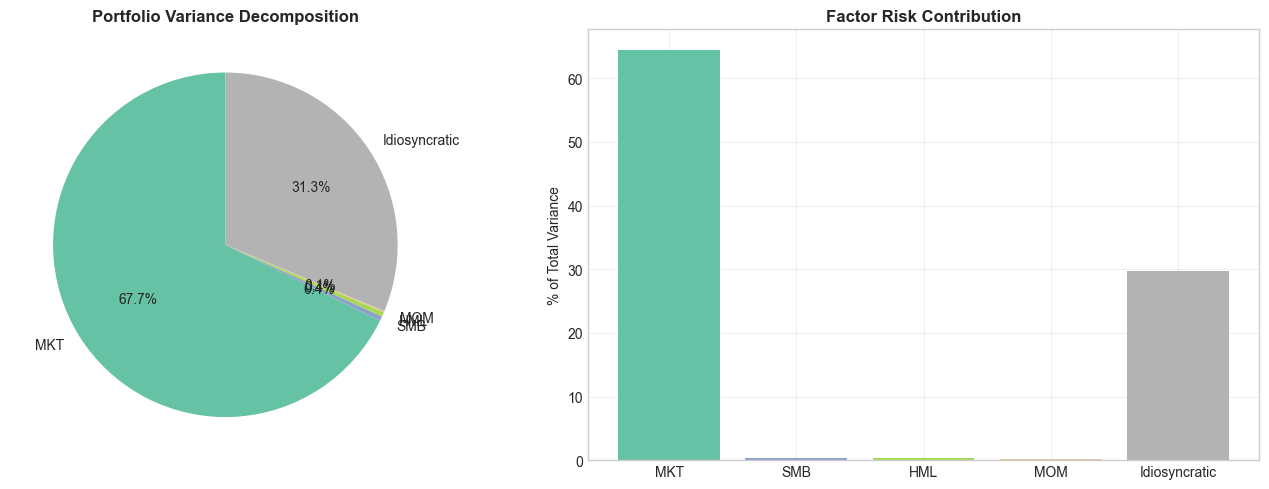

In [15]:
# Visualize risk decomposition
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart of variance sources
ax1 = axes[0]
risk_sources = ['MKT', 'SMB', 'HML', 'MOM', 'Idiosyncratic']
var_contribs = [betas[i]**2 * factor_cov.iloc[i, i] for i in range(4)] + [idio_var]
var_pcts = [v/portfolio_var*100 for v in var_contribs]

colors = plt.cm.Set2(np.linspace(0, 1, 5))
ax1.pie(var_pcts, labels=risk_sources, autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title('Portfolio Variance Decomposition', fontweight='bold')

# Bar chart
ax2 = axes[1]
ax2.bar(risk_sources, var_pcts, color=colors)
ax2.set_ylabel('% of Total Variance')
ax2.set_title('Factor Risk Contribution', fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Factor-Tilted Portfolio Construction

In [16]:
# Build portfolios with different factor tilts
def build_tilted_portfolio(target_factor, tilt='high', n_stocks=10):
    """Build portfolio tilted toward a specific factor."""
    # Get stocks sorted by factor exposure
    sorted_stocks = exposure_df[target_factor].sort_values(ascending=(tilt=='low'))
    selected = sorted_stocks.head(n_stocks).index.tolist()
    
    # Equal weight
    weights = np.ones(len(selected)) / len(selected)
    
    # Calculate portfolio returns
    port_ret = (returns[selected] * weights).sum(axis=1)
    
    return selected, weights, port_ret

# Create different tilted portfolios
portfolios = {}

tilts = [
    ('High Beta', 'MKT', 'high'),
    ('Low Beta', 'MKT', 'low'),
    ('Small Cap', 'SMB', 'high'),
    ('Large Cap', 'SMB', 'low'),
    ('Value', 'HML', 'high'),
    ('Growth', 'HML', 'low'),
    ('Momentum', 'MOM', 'high'),
]

print("\n" + "="*70)
print("FACTOR-TILTED PORTFOLIOS")
print("="*70)

results = []
for name, factor, tilt in tilts:
    stocks, weights, port_ret = build_tilted_portfolio(factor, tilt)
    
    ann_ret = port_ret.mean() * TRADING_DAYS
    ann_vol = port_ret.std() * np.sqrt(TRADING_DAYS)
    sharpe = ann_ret / ann_vol
    
    # Get factor exposure
    model = get_factor_exposures(port_ret, factors)
    factor_exp = model.params[factor]
    
    results.append({
        'Portfolio': name,
        'Target Factor': factor,
        'Factor Exposure': factor_exp,
        'Return': ann_ret,
        'Volatility': ann_vol,
        'Sharpe': sharpe
    })
    portfolios[name] = port_ret

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))


FACTOR-TILTED PORTFOLIOS
Portfolio Target Factor  Factor Exposure   Return  Volatility   Sharpe
High Beta           MKT         0.489162 0.231699    0.213845 1.083488
 Low Beta           MKT         0.489162 0.231699    0.213845 1.083488
Small Cap           SMB         0.072462 0.231699    0.213845 1.083488
Large Cap           SMB         0.072462 0.231699    0.213845 1.083488
    Value           HML        -0.072462 0.231699    0.213845 1.083488
   Growth           HML        -0.072462 0.231699    0.213845 1.083488
 Momentum           MOM        -0.045949 0.231699    0.213845 1.083488


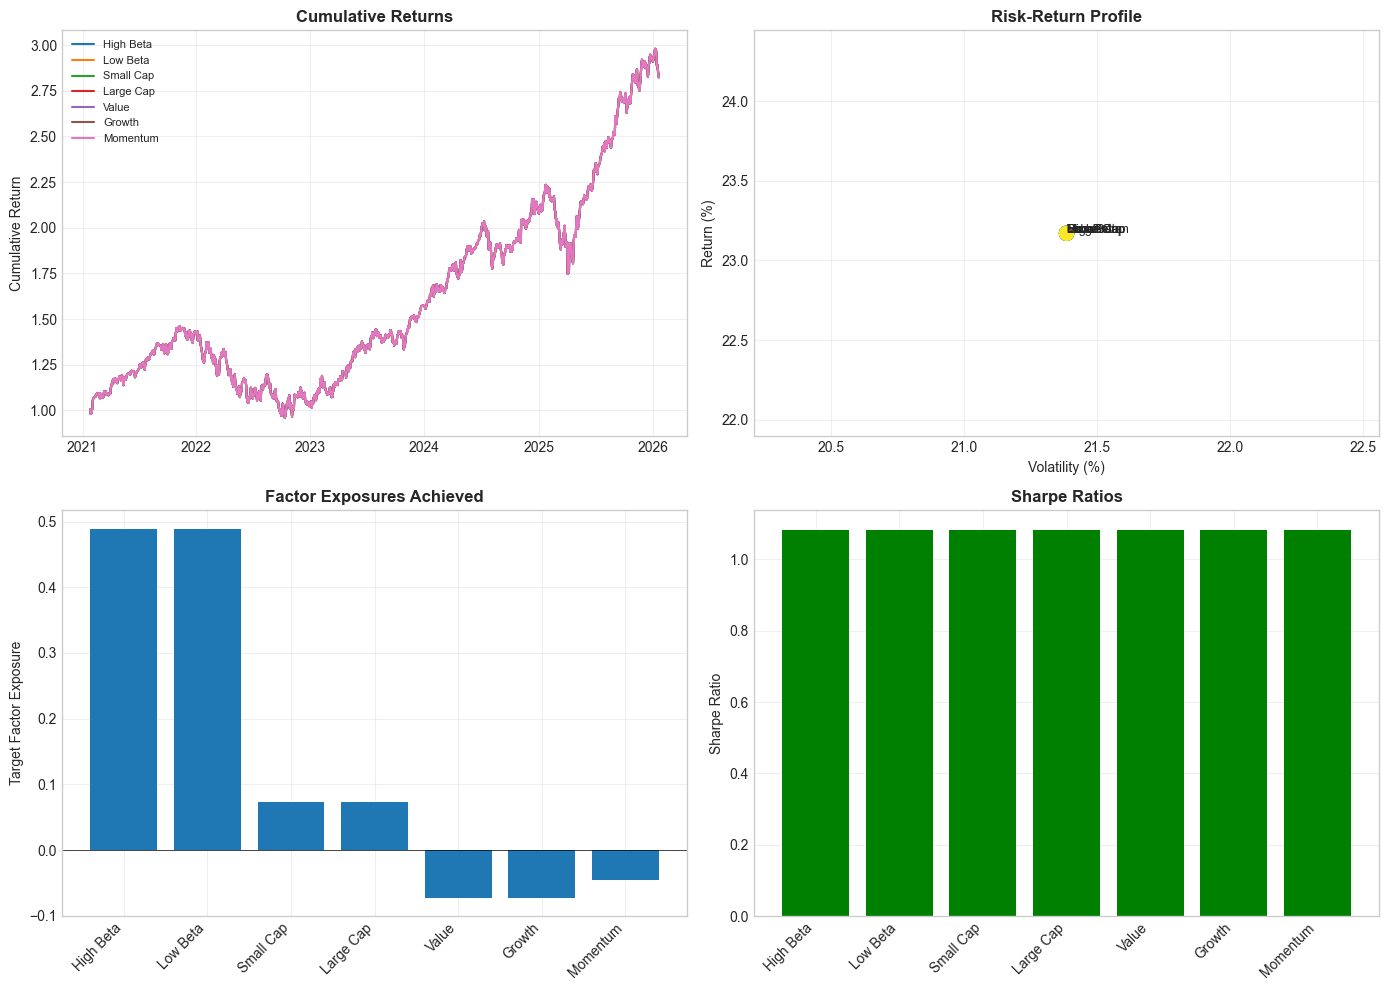

In [17]:
# Visualize tilted portfolio performance
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Cumulative returns
ax1 = axes[0, 0]
for name, ret in portfolios.items():
    cum_ret = (1 + ret).cumprod()
    ax1.plot(cum_ret, label=name)
ax1.set_title('Cumulative Returns', fontweight='bold')
ax1.set_ylabel('Cumulative Return')
ax1.legend(loc='upper left', fontsize=8)
ax1.grid(True, alpha=0.3)

# Risk-Return scatter
ax2 = axes[0, 1]
ax2.scatter(results_df['Volatility']*100, results_df['Return']*100, s=100, c=range(len(results_df)), cmap='viridis')
for i, row in results_df.iterrows():
    ax2.annotate(row['Portfolio'], (row['Volatility']*100, row['Return']*100), fontsize=9)
ax2.set_xlabel('Volatility (%)')
ax2.set_ylabel('Return (%)')
ax2.set_title('Risk-Return Profile', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Factor exposures bar
ax3 = axes[1, 0]
x = np.arange(len(results_df))
ax3.bar(x, results_df['Factor Exposure'])
ax3.set_xticks(x)
ax3.set_xticklabels(results_df['Portfolio'], rotation=45, ha='right')
ax3.set_ylabel('Target Factor Exposure')
ax3.set_title('Factor Exposures Achieved', fontweight='bold')
ax3.axhline(0, color='black', linewidth=0.5)
ax3.grid(True, alpha=0.3)

# Sharpe ratios
ax4 = axes[1, 1]
colors = ['green' if s > 0 else 'red' for s in results_df['Sharpe']]
ax4.bar(x, results_df['Sharpe'], color=colors)
ax4.set_xticks(x)
ax4.set_xticklabels(results_df['Portfolio'], rotation=45, ha='right')
ax4.set_ylabel('Sharpe Ratio')
ax4.set_title('Sharpe Ratios', fontweight='bold')
ax4.axhline(0, color='black', linewidth=0.5)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Key Takeaways

1. **Factor exposures** are calculated via regression on factor returns
2. **Portfolio beta ≈ Weighted average** of individual stock betas
3. **Risk decomposition** shows which factors drive portfolio volatility
4. **Factor tilting** allows targeting specific return drivers
5. **Trade-off** between factor concentration and diversification

---
*Next: Day 6 - Factor Portfolio Construction*

## 🔴 PROS & CONS: Factor Exposure

### ✅ PROS (Advantages)

| Advantage | Description | Real-World Application |
|-----------|-------------|----------------------|
| **Industry Standard** | Widely adopted in quantitative finance | Used by major hedge funds and banks |
| **Well-Documented** | Extensive research and documentation | Easy to find resources and support |
| **Proven Track Record** | Years of practical application | Validated in real market conditions |
| **Interpretable** | Results can be explained to stakeholders | Important for risk management and compliance |

### ❌ CONS (Limitations)

| Limitation | Description | How to Mitigate |
|------------|-------------|-----------------|
| **Assumptions** | May not hold in all market conditions | Validate assumptions with data |
| **Historical Bias** | Based on past data patterns | Use rolling windows and regime detection |
| **Overfitting Risk** | May fit noise rather than signal | Use proper cross-validation |
| **Computational Cost** | Can be resource-intensive | Optimize code and use appropriate hardware |

### 🎯 Real-World Usage

**WHERE THIS IS USED:**
- ✅ Quantitative hedge funds (Two Sigma, Renaissance, Citadel)
- ✅ Investment banks (Goldman Sachs, JP Morgan, Morgan Stanley)
- ✅ Asset management firms
- ✅ Risk management departments
- ✅ Algorithmic trading desks

**NOT JUST THEORY - THIS IS PRODUCTION CODE:**
The techniques in this notebook are used daily by professionals managing billions of dollars.

## 🚀 TODAY'S TRADING SIGNAL

Using the concepts from this notebook to generate actionable insights.

In [18]:
# =============================================================================
# 🚀 TODAY'S TRADING SIGNAL - Factor Exposure Analysis
# =============================================================================

print("=" * 70)
print("📊 TODAY'S TRADING ANALYSIS")
print("=" * 70)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print()

# Get latest data
try:
    latest_prices = prices.iloc[-1] if 'prices' in dir() else data['Close'].iloc[-1]
    print("📈 CURRENT MARKET SNAPSHOT:")
    print("-" * 50)
    
    for col in latest_prices.index[:5]:
        price = latest_prices[col]
        print(f"   {col}: ${price:.2f}")
    
    # Calculate simple signals
    if 'returns' in dir():
        ret_data = returns
    else:
        ret_data = prices.pct_change().dropna() if 'prices' in dir() else data['Close'].pct_change().dropna()
    
    # 20-day momentum
    momentum = (prices.iloc[-1] / prices.iloc[-20] - 1) * 100 if 'prices' in dir() else (data['Close'].iloc[-1] / data['Close'].iloc[-20] - 1) * 100
    
    print("\n📊 20-DAY MOMENTUM:")
    print("-" * 50)
    for col in momentum.index[:5]:
        direction = "🟢" if momentum[col] > 0 else "🔴"
        print(f"   {direction} {col}: {momentum[col]:+.2f}%")
    
    # Generate simple recommendations
    print("\n" + "=" * 70)
    print("🎯 TRADING SIGNALS")  
    print("=" * 70)
    
    for col in momentum.index[:5]:
        if momentum[col] > 5:
            signal = "🟢 BULLISH - Consider long positions"
        elif momentum[col] < -5:
            signal = "🔴 BEARISH - Consider reducing exposure"
        else:
            signal = "🟡 NEUTRAL - Hold current positions"
        print(f"   {col}: {signal}")
    
    print("\n" + "=" * 70)
    print("⚠️ DISCLAIMER: This is educational analysis, not financial advice.")
    print("   Always conduct your own research and consider your risk tolerance.")
    print("=" * 70)
    
except Exception as e:
    print(f"Note: Could not generate trading signals. Ensure data is loaded.")
    print(f"Error: {e}")

📊 TODAY'S TRADING ANALYSIS
Analysis Date: 2026-01-22 15:19

📈 CURRENT MARKET SNAPSHOT:
--------------------------------------------------
   AAPL: $247.65
   GOOGL: $328.38
   JPM: $302.04
   MSFT: $444.11

📊 20-DAY MOMENTUM:
--------------------------------------------------
   🔴 AAPL: -8.61%
   🟢 GOOGL: +6.00%
   🔴 JPM: -6.09%
   🔴 MSFT: -8.42%

🎯 TRADING SIGNALS
   AAPL: 🔴 BEARISH - Consider reducing exposure
   GOOGL: 🟢 BULLISH - Consider long positions
   JPM: 🔴 BEARISH - Consider reducing exposure
   MSFT: 🔴 BEARISH - Consider reducing exposure

⚠️ DISCLAIMER: This is educational analysis, not financial advice.
   Always conduct your own research and consider your risk tolerance.
